In [1]:
from random import randint
from numpy import array
from numpy import argmax
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
# generate a sequence of random numbers in [0, n_features)
def generate_sequence(length, n_features):
    return [randint(0, n_features-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_features):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_features)]
        vector[value] = 1
        encoding.append(vector)
    return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

# generate one example for an lstm
def generate_example(length, n_features, out_index):
    # generate sequence
    sequence = generate_sequence(length, n_features)
    # one hot encode
    encoded = one_hot_encode(sequence, n_features)
    # reshape sequence to be 3D
    X = encoded.reshape((1, length, n_features))
    # select output
    y = encoded[out_index].reshape(1, n_features)
    return X, y

#Vanilla LSTMs

In [3]:
# define model
length = 5
n_features = 10
out_index = 2
model = Sequential()
model.add(LSTM(25, input_shape=(length, n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                3600      
_________________________________________________________________
dense (Dense)                (None, 10)                260       
Total params: 3,860
Trainable params: 3,860
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
# fit model
for i in range(10000):
    X, y = generate_example(length, n_features, out_index)
    model.fit(X, y, epochs=1, verbose=False)

In [5]:
# evaluate model
correct = 0
for i in range(100):
    X, y = generate_example(length, n_features, out_index)
    yhat = model.predict(X)
    if one_hot_decode(yhat) == one_hot_decode(y):
        correct += 1
print('Accuracy: %f' % ((correct/100)*100.0))

Accuracy: 100.000000


In [6]:
# prediction on new data
X, y = generate_example(length, n_features, out_index)
yhat = model.predict(X)
print('Sequence: %s' % [one_hot_decode(x) for x in X])
print('Expected: %s' % one_hot_decode(y))
print('Predicted: %s' % one_hot_decode(yhat))

Sequence: [[8, 1, 9, 5, 5]]
Expected: [9]
Predicted: [9]


#Stacked LSTMs

In [7]:
from math import sin
from math import pi
from math import exp
from random import random
from random import randint
from random import uniform
from numpy import array
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [8]:
# generate damped sine wave in [0,1]
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]

# generate input and output pairs of damped sine waves
def generate_examples(length, n_patterns, output):
    X, y = list(), list()
    for _ in range(n_patterns):
        p = randint(10, 20)
        d = uniform(0.01, 0.1)
        sequence = generate_sequence(length + output, p, d)
        X.append(sequence[:-output])
        y.append(sequence[-output:])
    X = array(X).reshape(n_patterns, length, 1)
    y = array(y).reshape(n_patterns, output)
    return X, y

In [9]:
# configure problem
length = 50
output = 5

In [10]:
# define model
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1)))
model.add(LSTM(20))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 20)            1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total params: 5,145
Trainable params: 5,145
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# fit model
X, y = generate_examples(length, 10000, output)
history = model.fit(X, y, batch_size=10, epochs=100, verbose=False)

dict_keys(['loss'])


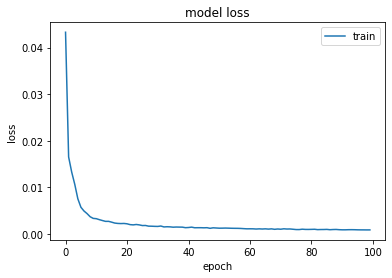

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [13]:
# evaluate model
X, y = generate_examples(length, 1000, output)
loss = model.evaluate(X, y, verbose=0)
print('MAE: %f' % loss)

MAE: 0.000613


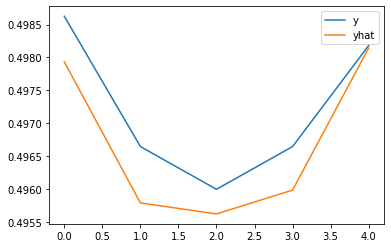

In [14]:
# prediction on new data
X, y = generate_examples(length, 1, output)
yhat = model.predict(X, verbose=0)
pyplot.plot(y[0], label='y')
pyplot.plot(yhat[0], label='yhat')
pyplot.legend()
pyplot.show()

#CNN LSTMs

In [15]:
from random import random
from random import randint
from numpy import array
from numpy import zeros
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed

In [16]:
# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    # define the scope of the next step
    lower = max(0, last_step-1)
    upper = min(last_frame.shape[0]-1, last_step+1)
    # choose the row index for the next step
    step = randint(lower, upper)
    # copy the prior frame
    frame = last_frame.copy()
    # add the new step
    frame[step, column] = 1
    return frame, step

# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    frames = list()
    # create the first frame
    frame = zeros((size,size))
    step = randint(0, size-1)
    # decide if we are heading left or right
    right = 1 if random() < 0.5 else 0
    col = 0 if right else size-1
    frame[step, col] = 1
    frames.append(frame)
    # create all remaining frames
    for i in range(1, size):
        col = i if right else size-1-i
        frame, step = next_frame(step, frame, col)
        frames.append(frame)
    return frames, right

# generate multiple sequences of frames and reshape for network input
def generate_examples(size, n_patterns):
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    # resize as [samples, timesteps, width, height, channels]
    X = array(X).reshape(n_patterns, size, size, size, 1)
    y = array(y).reshape(n_patterns, 1)
    return X, y

In [17]:
# configure problem
size = 50

In [18]:
# define the model
model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu'), input_shape=(None,size,size,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 49, 49, 2)   10        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 24, 24, 2)   0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1152)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                240600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 240,661
Trainable params: 240,661
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# fit model
X, y = generate_examples(size, 5000)
history = model.fit(X, y, batch_size=32, epochs=100, verbose=False)

dict_keys(['loss', 'acc'])


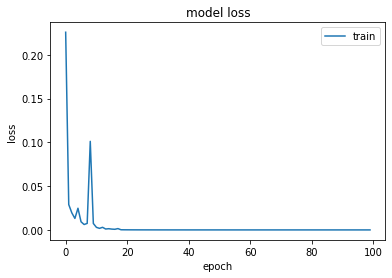

In [20]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [21]:
# evaluate model
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0)
print('loss: %f, acc: %f' % (loss, acc*100))

loss: 0.000000, acc: 100.000000


In [22]:
# prediction on new data
X, y = generate_examples(size, 1)
yhat = model.predict_classes(X, verbose=0)
expected = "Right" if y[0]==1 else "Left"
predicted = "Right" if yhat[0]==1 else "Left"
print('Expected: %s, Predicted: %s' % (expected, predicted))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Expected: Right, Predicted: Right


#Encoder-Decoder LSTMs

In [23]:
from random import seed
from random import randint
from numpy import array
import math
from math import ceil
from math import log10
from math import sqrt
from numpy import argmax
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

In [24]:
# generate lists of random integers and their sum
def random_sum_pairs(n_examples, n_numbers, largest):
    X, y = list(), list()
    for i in range(n_examples):
        in_pattern = [randint(1,largest) for _ in range(n_numbers)]
        out_pattern = sum(in_pattern)
        X.append(in_pattern)
        y.append(out_pattern)
    return X, y

# convert data to strings
def to_string(X, y, n_numbers, largest):
    max_length = n_numbers * ceil(log10(largest+1)) + n_numbers - 1
    Xstr = list()
    for pattern in X:
        strp = '+'.join([str(n) for n in pattern])
        strp = ''.join([' ' for _ in range(max_length-len(strp))]) + strp
        Xstr.append(strp)
    max_length = ceil(log10(n_numbers * (largest+1)))
    ystr = list()
    for pattern in y:
        strp = str(pattern)
        strp = ''.join([' ' for _ in range(max_length-len(strp))]) + strp
        ystr.append(strp)
    return Xstr, ystr

# integer encode strings
def integer_encode(X, y, alphabet):
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    Xenc = list()
    for pattern in X:
        integer_encoded = [char_to_int[char] for char in pattern]
        Xenc.append(integer_encoded)
    yenc = list()
    for pattern in y:
        integer_encoded = [char_to_int[char] for char in pattern]
        yenc.append(integer_encoded)
    return Xenc, yenc

# one hot encode
def one_hot_encode(X, y, max_int):
    Xenc = list()
    for seq in X:
        pattern = list()
        for index in seq:
            vector = [0 for _ in range(max_int)]
            vector[index] = 1
            pattern.append(vector)
        Xenc.append(pattern)
    yenc = list()
    for seq in y:
        pattern = list()
        for index in seq:
            vector = [0 for _ in range(max_int)]
            vector[index] = 1
            pattern.append(vector)
        yenc.append(pattern)
    return Xenc, yenc

# generate an encoded dataset
def generate_data(n_samples, n_numbers, largest, alphabet):
    # generate pairs
    X, y = random_sum_pairs(n_samples, n_numbers, largest)
    # convert to strings
    X, y = to_string(X, y, n_numbers, largest)
    # integer encode
    X, y = integer_encode(X, y, alphabet)
    # one hot encode
    X, y = one_hot_encode(X, y, len(alphabet))
    # return as numpy arrays
    X, y = array(X), array(y)
    return X, y

# invert encoding
def invert(seq, alphabet):
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    strings = list()
    for pattern in seq:
        string = int_to_char[argmax(pattern)]
        strings.append(string)
    return ''.join(strings)

In [25]:
# configure problem

# number of math terms
n_terms = 3

# largest value for any single input digit
largest = 10
# scope of possible symbols for each input or output time step
alphabet = [str(x) for x in range(10)] + ['+', ' ']

# size of alphabet: (12 for 0-9, + and ' ')
n_chars = len(alphabet)
# length of encoded input sequence (8 for '10+10+10')
n_in_seq_length = n_terms * ceil(log10(largest+1)) + n_terms - 1
# length of encoded output sequence (2 for '30')
n_out_seq_length = ceil(log10(n_terms * (largest+1)))

In [26]:
# define LSTM
model = Sequential()
model.add(LSTM(75, input_shape=(n_in_seq_length, n_chars)))
model.add(RepeatVector(n_out_seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_chars, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 75)                26400     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 75)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 2, 50)             25200     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 2, 12)             612       
Total params: 52,212
Trainable params: 52,212
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
# fit LSTM
X, y = generate_data(75000, n_terms, largest, alphabet)
history = model.fit(X, y, epochs=100, batch_size=32, verbose=False)

dict_keys(['loss', 'accuracy'])


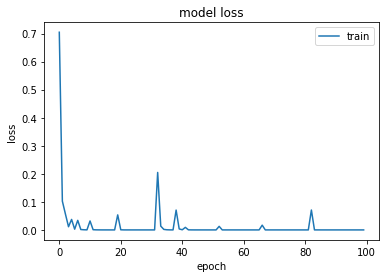

In [28]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [29]:
# evaluate LSTM
X, y = generate_data(100, n_terms, largest, alphabet)
loss, acc = model.evaluate(X, y, verbose=0)
print('Loss: %f, Accuracy: %f' % (loss, acc*100))

Loss: 0.000000, Accuracy: 100.000000


In [30]:
# predict
for _ in range(10):
    # generate an input-output pair
    X, y = generate_data(1, n_terms, largest, alphabet)
    # make prediction
    yhat = model.predict(X, verbose=0)
    # decode input, expected and predicted
    in_seq = invert(X[0], alphabet)
    out_seq = invert(y[0], alphabet)
    predicted = invert(yhat[0], alphabet)
    print('%s = %s (expect %s)' % (in_seq, predicted, out_seq))

   3+9+6 = 18 (expect 18)
   5+8+4 = 17 (expect 17)
   3+1+2 =  6 (expect  6)
   9+1+9 = 19 (expect 19)
  10+1+5 = 16 (expect 16)
   9+9+8 = 26 (expect 26)
   7+8+1 = 16 (expect 16)
   6+1+7 = 14 (expect 14)
  6+7+10 = 23 (expect 23)
  9+7+10 = 26 (expect 26)


#Bidirectional LSTMs

In [31]:
from random import random
from numpy import array
from numpy import cumsum
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

In [32]:
# create a cumulative sum sequence
def get_sequence(n_timesteps):
# create a sequence of random numbers in [0,1]
    X = array([random() for _ in range(n_timesteps)])
    # calculate cut-off value to change class values
    limit = n_timesteps/4.0
    # determine the class outcome for each item in cumulative sequence
    y = array([0 if x < limit else 1 for x in cumsum(X)])
    return X, y


# create multiple samples of cumulative sum sequences
def get_sequences(n_sequences, n_timesteps):
    seqX, seqY = list(), list()
    # create and store sequences
    for _ in range(n_sequences):
        X, y = get_sequence(n_timesteps)
        seqX.append(X)
        seqY.append(y)
    # reshape input and output for lstm
    seqX = array(seqX).reshape(n_sequences, n_timesteps, 1)
    seqY = array(seqY).reshape(n_sequences, n_timesteps, 1)
    return seqX, seqY

In [33]:
# define problem
n_timesteps = 10

In [34]:
# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(n_timesteps, 1)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 10, 100)           20800     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 1)             101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# train LSTM
X, y = get_sequences(50000, n_timesteps)
history = model.fit(X, y, epochs=100, batch_size=10, verbose=False)

dict_keys(['loss', 'acc'])


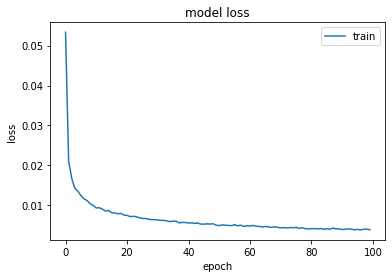

In [36]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [37]:
# evaluate LSTM
X, y = get_sequences(100, n_timesteps)
loss, acc = model.evaluate(X, y, verbose=0)
print('Loss: %f, Accuracy: %f' % (loss, acc*100))

Loss: 0.002778, Accuracy: 100.000000


In [38]:
# make predictions
for _ in range(10):
    X, y = get_sequences(1, n_timesteps)
    yhat = model.predict_classes(X, verbose=0)
    exp, pred = y.reshape(n_timesteps), yhat.reshape(n_timesteps)
    print('y=%s, yhat=%s, correct=%s' % (exp, pred, array_equal(exp,pred)))

y=[0 0 0 1 1 1 1 1 1 1], yhat=[0 0 0 1 1 1 1 1 1 1], correct=True
y=[0 0 0 0 1 1 1 1 1 1], yhat=[0 0 0 0 1 1 1 1 1 1], correct=True
y=[0 0 0 1 1 1 1 1 1 1], yhat=[0 0 0 1 1 1 1 1 1 1], correct=True
y=[0 0 0 0 0 1 1 1 1 1], yhat=[0 0 0 0 0 1 1 1 1 1], correct=True
y=[0 0 0 0 0 1 1 1 1 1], yhat=[0 0 0 0 0 1 1 1 1 1], correct=True
y=[0 0 0 0 0 0 1 1 1 1], yhat=[0 0 0 0 0 0 1 1 1 1], correct=True
y=[0 0 0 0 0 1 1 1 1 1], yhat=[0 0 0 0 0 1 1 1 1 1], correct=True
y=[0 0 0 0 0 0 0 1 1 1], yhat=[0 0 0 0 0 0 0 1 1 1], correct=True
y=[0 0 0 1 1 1 1 1 1 1], yhat=[0 0 0 1 1 1 1 1 1 1], correct=True
y=[0 0 0 0 1 1 1 1 1 1], yhat=[0 0 0 0 1 1 1 1 1 1], correct=True


#Generative LSTMs

In [39]:
from random import random
from numpy import array
from matplotlib import pyplot
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [40]:
# generate a rectangle with random width and height
def random_rectangle():
    width, height = random(), random()
    points = list()
    # bottom left
    points.append([0.0, 0.0])
    # bottom right
    points.append([width, 0.0])
    # top right
    points.append([width, height])
    # top left
    points.append([0.0, height])
    return points

# plot a rectangle
def plot_rectangle(rect):
    # close the rectangle path
    rect.append(rect[0])
    # define path
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(rect, codes)
    axis = pyplot.gca()
    patch = PathPatch(path)
    # add shape to plot
    axis.add_patch(patch)
    axis.set_xlim(-0.1,1.1)
    axis.set_ylim(-0.1,1.1)
    pyplot.show()

# generate input and output sequences for one random rectangle
def get_samples():
    # generate rectangle
    rect = random_rectangle()
    X, y = list(), list()
    # create input output pairs for each coordinate
    for i in range(1, len(rect)):
        X.append(rect[i-1])
        y.append(rect[i])
    # convert input sequence shape to have 1 time step and 2 features
    X, y = array(X), array(y)
    X = X.reshape((X.shape[0], 1, 2))
    return X, y

# use a fit LSTM model to generate a new rectangle from scratch
def generate_rectangle(model):
    rect = list()
    # use [0,0] to seed the generation process
    last = array([0.0,0.0]).reshape((1, 1, 2))
    rect.append([[y for y in x] for x in last[0]][0])
    # generate the remaining 3 coordinates
    for i in range(3):
        # predict the next coordinate
        yhat = model.predict(last, verbose=0)
        # use this output as input for the next prediction
        last = yhat.reshape((1, 1, 2))
        # store coordinate
        rect.append([[y for y in x] for x in last[0]][0])
    return rect

In [41]:
# define model
model = Sequential()
model.add(LSTM(10, input_shape=(1, 2)))
model.add(Dense(2, activation='linear'))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10)                520       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 542
Trainable params: 542
Non-trainable params: 0
_________________________________________________________________
None


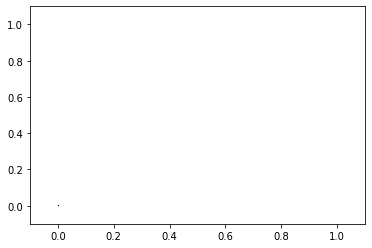

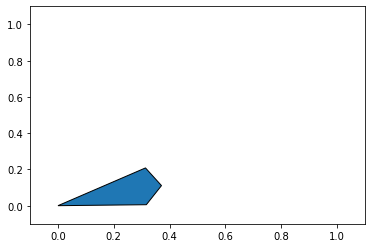

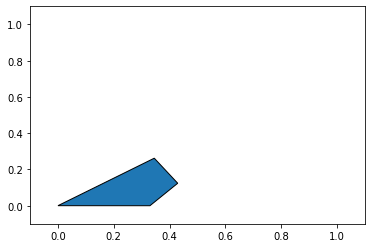

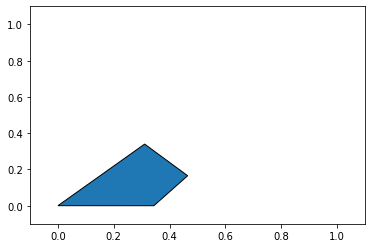

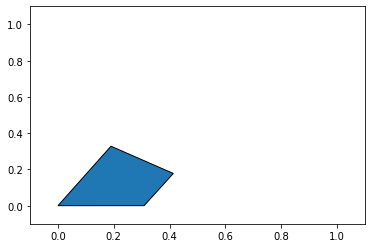

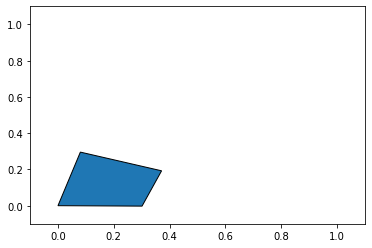

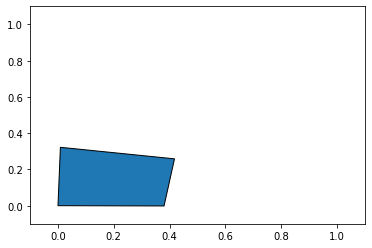

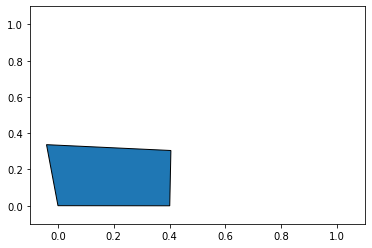

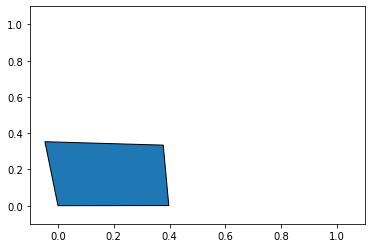

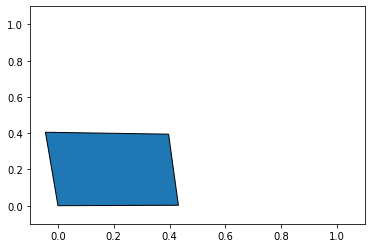

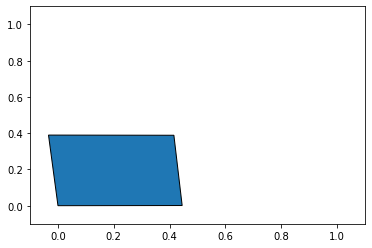

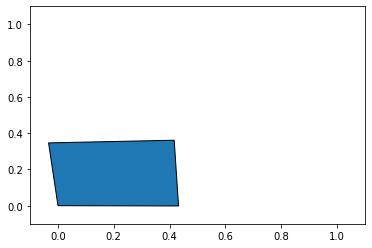

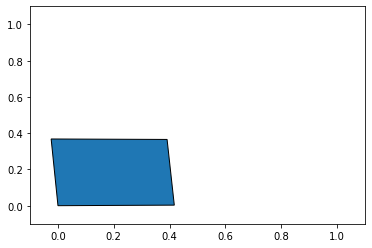

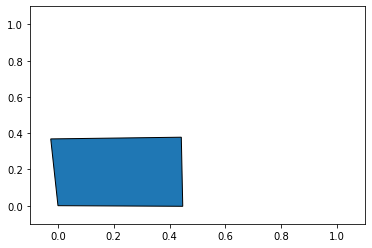

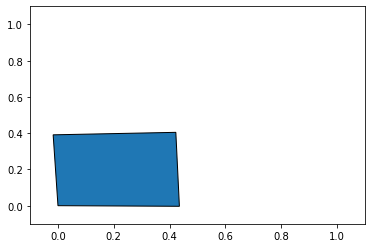

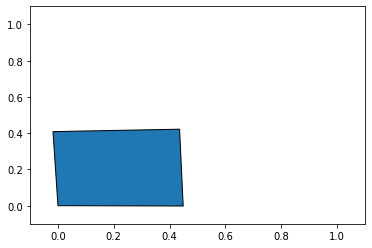

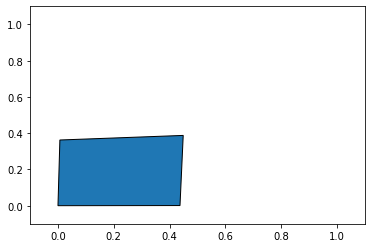

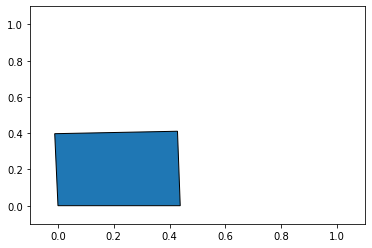

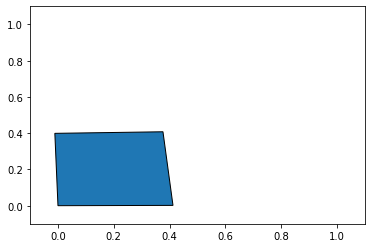

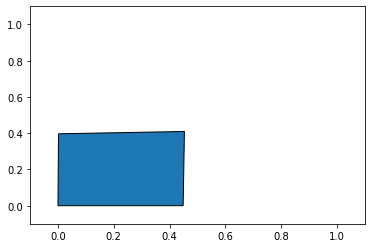

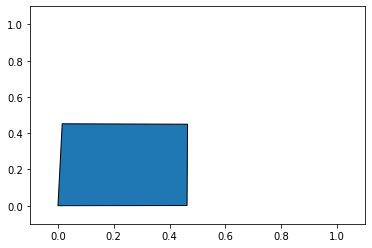

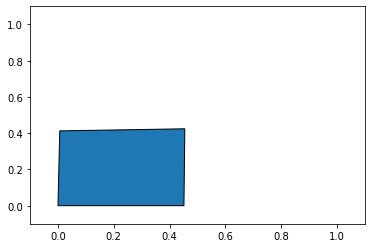

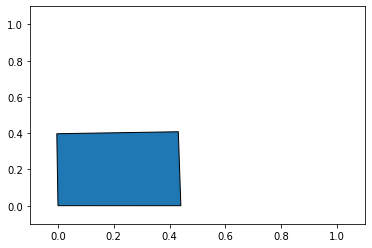

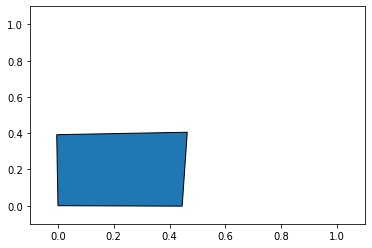

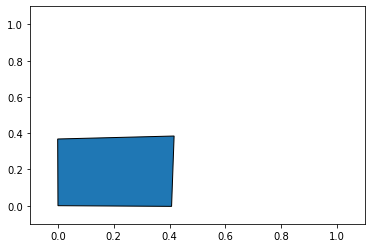

In [42]:
# fit model
for i in range(25000):
    X, y = get_samples()
    model.fit(X, y, epochs=1, verbose=False, shuffle=False)

    if i % 1000 == 0:
        rect = generate_rectangle(model)
        plot_rectangle(rect)

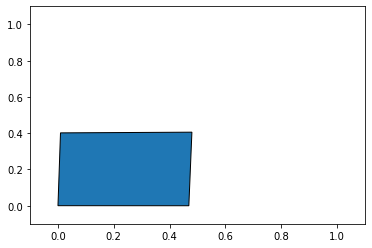

In [43]:
# generate new shapes from scratch
rect = generate_rectangle(model)
plot_rectangle(rect)

In [44]:
rect

[[0.0, 0.0],
 [0.46905124, -0.0003078431],
 [0.4800158, 0.40562552],
 [0.009084702, 0.40176326],
 [0.0, 0.0]]

Credit: Jason Brownlee